# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

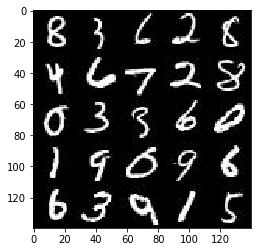

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

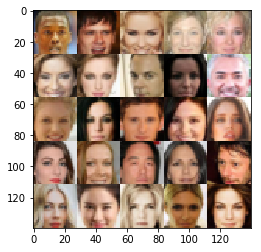

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/varsha/anaconda3/envs/project2_deep_learning/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images = tf.placeholder(tf.float32, shape=(None, image_width,
                                                    image_height, image_channels))
    z_channel = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_images, z_channel, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/varsha/anaconda3/envs/project2_deep_learning/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/varsha/anaconda3/envs/project2_deep_learning/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/varsha/anaconda3/envs/project2_deep_learning/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/varsha/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/varsha/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().sta

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# NOTE: This and the code that follows is based largely on the tutorial at https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')    
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, keep_prob)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, keep_prob)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, keep_prob)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
     
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, keep_prob, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, keep_prob, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, keep_prob, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
  
        # Last layer of the generator must not batch normalize and the generator must be bigger than the discriminator for best results
        x4 = tf.layers.conv2d_transpose(x3, 64, 4, strides=1, padding='same')
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim ,4,  strides=2,  padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
class GAN:
    def __init__(self, z_size, real_size, learning_rate, alpha=0.2, beta1=0.5):
  #      tf.reset_default_graph()
        
        self.input_real, self.input_z, learning_rate_tensor = model_inputs(real_size[1],real_size[2], 
                                                     real_size[3], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(z_dim, data_shape, learning_rate, alpha=0.2, beta1=beta1)
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 49 ,net.input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Discriminator Loss: 1.3263... Generator Loss: 0.9009
Epoch 1/2... Step 20... Discriminator Loss: 4.4714... Generator Loss: 0.0249
Epoch 1/2... Step 30... Discriminator Loss: 2.3259... Generator Loss: 0.1997
Epoch 1/2... Step 40... Discriminator Loss: 0.1713... Generator Loss: 3.6171
Epoch 1/2... Step 50... Discriminator Loss: 0.3486... Generator Loss: 9.8756
Epoch 1/2... Step 60... Discriminator Loss: 0.2699... Generator Loss: 6.5913
Epoch 1/2... Step 70... Discriminator Loss: 0.0994... Generator Loss: 3.5292
Epoch 1/2... Step 80... Discriminator Loss: 0.1037... Generator Loss: 3.1963
Epoch 1/2... Step 90... Discriminator Loss: 1.2236... Generator Loss: 0.4885
Epoch 1/2... Step 100... Discriminator Loss: 0.1979... Generator Loss: 2.0654


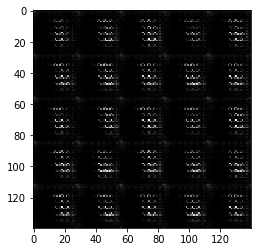

Epoch 1/2... Step 110... Discriminator Loss: 0.1238... Generator Loss: 4.0170
Epoch 1/2... Step 120... Discriminator Loss: 0.1496... Generator Loss: 9.6667
Epoch 1/2... Step 130... Discriminator Loss: 0.2895... Generator Loss: 2.0164
Epoch 1/2... Step 140... Discriminator Loss: 0.2376... Generator Loss: 2.5301
Epoch 1/2... Step 150... Discriminator Loss: 0.2327... Generator Loss: 2.6791
Epoch 1/2... Step 160... Discriminator Loss: 0.8829... Generator Loss: 1.5032
Epoch 1/2... Step 170... Discriminator Loss: 1.2040... Generator Loss: 0.9979
Epoch 1/2... Step 180... Discriminator Loss: 0.5408... Generator Loss: 1.8907
Epoch 1/2... Step 190... Discriminator Loss: 0.2647... Generator Loss: 2.3799
Epoch 1/2... Step 200... Discriminator Loss: 0.1958... Generator Loss: 2.5304


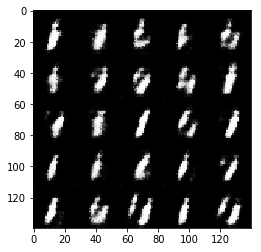

Epoch 1/2... Step 210... Discriminator Loss: 0.1681... Generator Loss: 3.8881
Epoch 1/2... Step 220... Discriminator Loss: 0.4098... Generator Loss: 1.9912
Epoch 1/2... Step 230... Discriminator Loss: 0.4715... Generator Loss: 2.6714
Epoch 1/2... Step 240... Discriminator Loss: 0.5229... Generator Loss: 1.9964
Epoch 1/2... Step 250... Discriminator Loss: 0.4314... Generator Loss: 2.0667
Epoch 1/2... Step 260... Discriminator Loss: 0.5626... Generator Loss: 1.7117
Epoch 1/2... Step 270... Discriminator Loss: 0.4101... Generator Loss: 2.1033
Epoch 1/2... Step 280... Discriminator Loss: 0.3872... Generator Loss: 3.1011
Epoch 1/2... Step 290... Discriminator Loss: 0.7883... Generator Loss: 1.9895
Epoch 1/2... Step 300... Discriminator Loss: 0.6447... Generator Loss: 1.2735


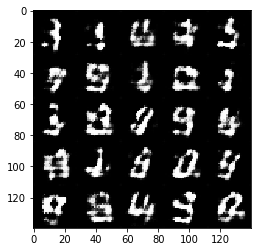

Epoch 1/2... Step 310... Discriminator Loss: 0.4446... Generator Loss: 2.1117
Epoch 1/2... Step 320... Discriminator Loss: 0.3172... Generator Loss: 2.6202
Epoch 1/2... Step 330... Discriminator Loss: 0.7160... Generator Loss: 2.9885
Epoch 1/2... Step 340... Discriminator Loss: 0.3294... Generator Loss: 2.6877
Epoch 1/2... Step 350... Discriminator Loss: 0.4831... Generator Loss: 1.7904
Epoch 1/2... Step 360... Discriminator Loss: 0.4587... Generator Loss: 2.4503
Epoch 1/2... Step 370... Discriminator Loss: 0.3915... Generator Loss: 2.5745
Epoch 1/2... Step 380... Discriminator Loss: 0.6135... Generator Loss: 1.9728
Epoch 1/2... Step 390... Discriminator Loss: 0.6725... Generator Loss: 2.2014
Epoch 1/2... Step 400... Discriminator Loss: 0.6369... Generator Loss: 1.4769


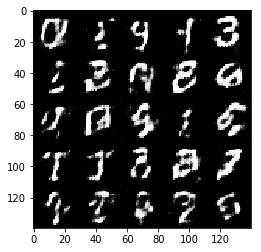

Epoch 1/2... Step 410... Discriminator Loss: 0.5997... Generator Loss: 1.1457
Epoch 1/2... Step 420... Discriminator Loss: 1.0913... Generator Loss: 0.5782
Epoch 1/2... Step 430... Discriminator Loss: 0.4526... Generator Loss: 1.6454
Epoch 1/2... Step 440... Discriminator Loss: 0.4846... Generator Loss: 2.0175
Epoch 1/2... Step 450... Discriminator Loss: 0.4225... Generator Loss: 2.0239
Epoch 1/2... Step 460... Discriminator Loss: 1.2114... Generator Loss: 0.6386
Epoch 1/2... Step 470... Discriminator Loss: 0.6141... Generator Loss: 1.0862
Epoch 1/2... Step 480... Discriminator Loss: 0.5147... Generator Loss: 1.4688
Epoch 1/2... Step 490... Discriminator Loss: 0.7288... Generator Loss: 2.7279
Epoch 1/2... Step 500... Discriminator Loss: 0.5397... Generator Loss: 1.9778


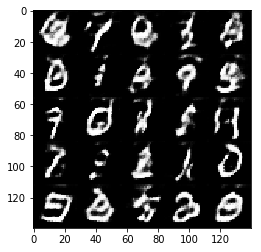

Epoch 1/2... Step 510... Discriminator Loss: 0.6083... Generator Loss: 1.4082
Epoch 1/2... Step 520... Discriminator Loss: 0.5317... Generator Loss: 1.5922
Epoch 1/2... Step 530... Discriminator Loss: 0.8935... Generator Loss: 0.9873
Epoch 1/2... Step 540... Discriminator Loss: 0.6137... Generator Loss: 1.7998
Epoch 1/2... Step 550... Discriminator Loss: 1.0024... Generator Loss: 3.2648
Epoch 1/2... Step 560... Discriminator Loss: 0.6142... Generator Loss: 1.4404
Epoch 1/2... Step 570... Discriminator Loss: 0.4473... Generator Loss: 2.2810
Epoch 1/2... Step 580... Discriminator Loss: 0.6513... Generator Loss: 1.1075
Epoch 1/2... Step 590... Discriminator Loss: 1.5174... Generator Loss: 0.4738
Epoch 1/2... Step 600... Discriminator Loss: 0.4931... Generator Loss: 1.9263


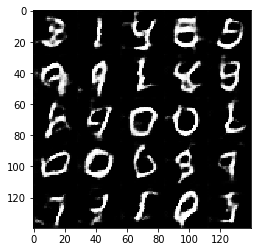

Epoch 1/2... Step 610... Discriminator Loss: 0.6551... Generator Loss: 2.4116
Epoch 1/2... Step 620... Discriminator Loss: 0.4989... Generator Loss: 1.9734
Epoch 1/2... Step 630... Discriminator Loss: 0.5771... Generator Loss: 1.1825
Epoch 1/2... Step 640... Discriminator Loss: 0.9237... Generator Loss: 0.8114
Epoch 1/2... Step 650... Discriminator Loss: 0.5436... Generator Loss: 2.2770
Epoch 1/2... Step 660... Discriminator Loss: 0.5520... Generator Loss: 1.4318
Epoch 1/2... Step 670... Discriminator Loss: 1.3595... Generator Loss: 0.4690
Epoch 1/2... Step 680... Discriminator Loss: 0.5222... Generator Loss: 1.5754
Epoch 1/2... Step 690... Discriminator Loss: 0.4728... Generator Loss: 1.8813
Epoch 1/2... Step 700... Discriminator Loss: 0.7780... Generator Loss: 0.8942


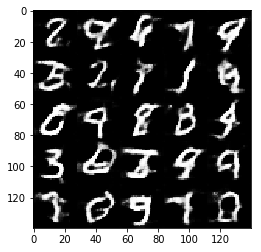

Epoch 1/2... Step 710... Discriminator Loss: 0.5635... Generator Loss: 2.1350
Epoch 1/2... Step 720... Discriminator Loss: 0.4230... Generator Loss: 1.7016
Epoch 1/2... Step 730... Discriminator Loss: 0.7046... Generator Loss: 1.0689
Epoch 1/2... Step 740... Discriminator Loss: 0.6351... Generator Loss: 1.0126
Epoch 1/2... Step 750... Discriminator Loss: 0.5948... Generator Loss: 1.4006
Epoch 1/2... Step 760... Discriminator Loss: 0.3865... Generator Loss: 1.6814
Epoch 1/2... Step 770... Discriminator Loss: 0.5366... Generator Loss: 3.0334
Epoch 1/2... Step 780... Discriminator Loss: 0.6577... Generator Loss: 2.8865
Epoch 1/2... Step 790... Discriminator Loss: 0.4522... Generator Loss: 2.0613
Epoch 1/2... Step 800... Discriminator Loss: 0.5162... Generator Loss: 0.9910


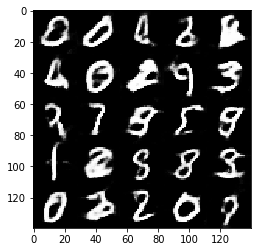

Epoch 1/2... Step 810... Discriminator Loss: 0.6937... Generator Loss: 0.9000
Epoch 1/2... Step 820... Discriminator Loss: 0.4471... Generator Loss: 1.6231
Epoch 1/2... Step 830... Discriminator Loss: 0.4203... Generator Loss: 1.8332
Epoch 1/2... Step 840... Discriminator Loss: 0.4971... Generator Loss: 2.0450
Epoch 1/2... Step 850... Discriminator Loss: 0.4680... Generator Loss: 1.5721
Epoch 1/2... Step 860... Discriminator Loss: 0.7135... Generator Loss: 2.5825
Epoch 1/2... Step 870... Discriminator Loss: 0.5139... Generator Loss: 1.7678
Epoch 1/2... Step 880... Discriminator Loss: 1.2327... Generator Loss: 4.6670
Epoch 1/2... Step 890... Discriminator Loss: 0.4721... Generator Loss: 1.8817
Epoch 1/2... Step 900... Discriminator Loss: 0.4642... Generator Loss: 1.3262


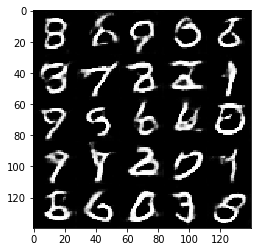

Epoch 1/2... Step 910... Discriminator Loss: 0.4268... Generator Loss: 1.6083
Epoch 1/2... Step 920... Discriminator Loss: 0.4731... Generator Loss: 2.2509
Epoch 1/2... Step 930... Discriminator Loss: 0.3580... Generator Loss: 2.1966
Epoch 2/2... Step 940... Discriminator Loss: 0.5101... Generator Loss: 1.2755
Epoch 2/2... Step 950... Discriminator Loss: 0.5905... Generator Loss: 1.2484
Epoch 2/2... Step 960... Discriminator Loss: 2.1552... Generator Loss: 0.1980
Epoch 2/2... Step 970... Discriminator Loss: 0.6410... Generator Loss: 1.4133
Epoch 2/2... Step 980... Discriminator Loss: 0.5530... Generator Loss: 1.9305
Epoch 2/2... Step 990... Discriminator Loss: 0.3233... Generator Loss: 1.9861
Epoch 2/2... Step 1000... Discriminator Loss: 0.4504... Generator Loss: 1.6743


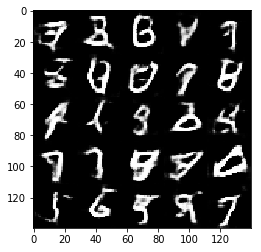

Epoch 2/2... Step 1010... Discriminator Loss: 0.6591... Generator Loss: 2.9663
Epoch 2/2... Step 1020... Discriminator Loss: 0.3597... Generator Loss: 2.1321
Epoch 2/2... Step 1030... Discriminator Loss: 0.5656... Generator Loss: 1.1893
Epoch 2/2... Step 1040... Discriminator Loss: 0.3886... Generator Loss: 2.0481
Epoch 2/2... Step 1050... Discriminator Loss: 0.2782... Generator Loss: 2.0257
Epoch 2/2... Step 1060... Discriminator Loss: 0.4082... Generator Loss: 2.4006
Epoch 2/2... Step 1070... Discriminator Loss: 0.2437... Generator Loss: 2.2913
Epoch 2/2... Step 1080... Discriminator Loss: 0.8417... Generator Loss: 0.7619
Epoch 2/2... Step 1090... Discriminator Loss: 0.7685... Generator Loss: 1.2049
Epoch 2/2... Step 1100... Discriminator Loss: 0.3885... Generator Loss: 2.7835


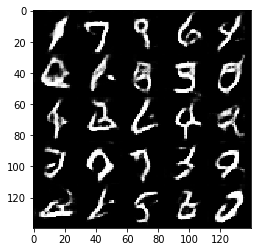

Epoch 2/2... Step 1110... Discriminator Loss: 0.2096... Generator Loss: 2.6406
Epoch 2/2... Step 1120... Discriminator Loss: 0.4671... Generator Loss: 1.4694
Epoch 2/2... Step 1130... Discriminator Loss: 0.3086... Generator Loss: 1.6678
Epoch 2/2... Step 1140... Discriminator Loss: 0.7049... Generator Loss: 4.3717
Epoch 2/2... Step 1150... Discriminator Loss: 0.3875... Generator Loss: 2.3278
Epoch 2/2... Step 1160... Discriminator Loss: 2.0629... Generator Loss: 0.2498
Epoch 2/2... Step 1170... Discriminator Loss: 0.6996... Generator Loss: 2.2496
Epoch 2/2... Step 1180... Discriminator Loss: 0.3465... Generator Loss: 2.0915
Epoch 2/2... Step 1190... Discriminator Loss: 0.3413... Generator Loss: 1.8739
Epoch 2/2... Step 1200... Discriminator Loss: 0.3879... Generator Loss: 1.8868


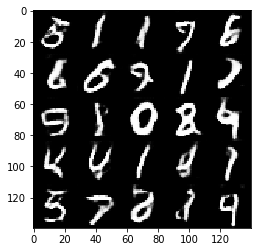

Epoch 2/2... Step 1210... Discriminator Loss: 0.2304... Generator Loss: 2.4932
Epoch 2/2... Step 1220... Discriminator Loss: 0.4055... Generator Loss: 1.4280
Epoch 2/2... Step 1230... Discriminator Loss: 0.1772... Generator Loss: 3.1025
Epoch 2/2... Step 1240... Discriminator Loss: 0.5500... Generator Loss: 1.2969
Epoch 2/2... Step 1250... Discriminator Loss: 0.2559... Generator Loss: 3.3592
Epoch 2/2... Step 1260... Discriminator Loss: 0.3490... Generator Loss: 2.0101
Epoch 2/2... Step 1270... Discriminator Loss: 0.6871... Generator Loss: 1.9224
Epoch 2/2... Step 1280... Discriminator Loss: 0.4832... Generator Loss: 2.3865
Epoch 2/2... Step 1290... Discriminator Loss: 0.3766... Generator Loss: 1.8784
Epoch 2/2... Step 1300... Discriminator Loss: 0.4057... Generator Loss: 1.8495


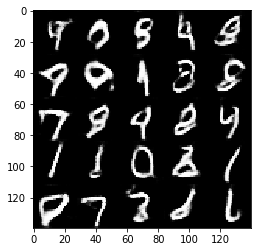

Epoch 2/2... Step 1310... Discriminator Loss: 0.3040... Generator Loss: 2.0467
Epoch 2/2... Step 1320... Discriminator Loss: 0.2133... Generator Loss: 2.5982
Epoch 2/2... Step 1330... Discriminator Loss: 1.1603... Generator Loss: 0.4884
Epoch 2/2... Step 1340... Discriminator Loss: 0.2631... Generator Loss: 2.3355
Epoch 2/2... Step 1350... Discriminator Loss: 0.2533... Generator Loss: 2.1812
Epoch 2/2... Step 1360... Discriminator Loss: 0.2209... Generator Loss: 2.5184
Epoch 2/2... Step 1370... Discriminator Loss: 0.3369... Generator Loss: 2.3037
Epoch 2/2... Step 1380... Discriminator Loss: 0.5996... Generator Loss: 1.2795
Epoch 2/2... Step 1390... Discriminator Loss: 0.3000... Generator Loss: 2.5645
Epoch 2/2... Step 1400... Discriminator Loss: 0.2476... Generator Loss: 2.7016


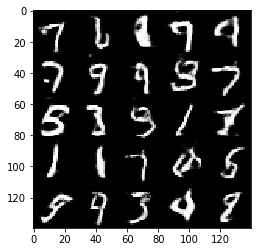

Epoch 2/2... Step 1410... Discriminator Loss: 0.4304... Generator Loss: 3.6467
Epoch 2/2... Step 1420... Discriminator Loss: 0.1829... Generator Loss: 2.5858
Epoch 2/2... Step 1430... Discriminator Loss: 0.2871... Generator Loss: 1.7030
Epoch 2/2... Step 1440... Discriminator Loss: 0.1752... Generator Loss: 2.7185
Epoch 2/2... Step 1450... Discriminator Loss: 0.5154... Generator Loss: 1.5061
Epoch 2/2... Step 1460... Discriminator Loss: 0.2959... Generator Loss: 2.3692
Epoch 2/2... Step 1470... Discriminator Loss: 0.3024... Generator Loss: 2.5451
Epoch 2/2... Step 1480... Discriminator Loss: 0.1839... Generator Loss: 2.1841
Epoch 2/2... Step 1490... Discriminator Loss: 1.9046... Generator Loss: 5.1313
Epoch 2/2... Step 1500... Discriminator Loss: 0.5519... Generator Loss: 2.0623


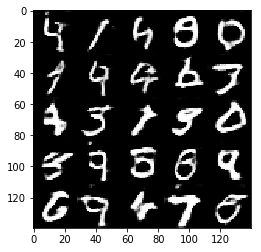

Epoch 2/2... Step 1510... Discriminator Loss: 0.4459... Generator Loss: 1.7795
Epoch 2/2... Step 1520... Discriminator Loss: 0.3376... Generator Loss: 2.2488
Epoch 2/2... Step 1530... Discriminator Loss: 0.3768... Generator Loss: 1.7042
Epoch 2/2... Step 1540... Discriminator Loss: 0.2438... Generator Loss: 2.4180
Epoch 2/2... Step 1550... Discriminator Loss: 0.3164... Generator Loss: 2.8640
Epoch 2/2... Step 1560... Discriminator Loss: 0.4799... Generator Loss: 1.6394
Epoch 2/2... Step 1570... Discriminator Loss: 0.2485... Generator Loss: 2.3941
Epoch 2/2... Step 1580... Discriminator Loss: 0.3790... Generator Loss: 1.6766
Epoch 2/2... Step 1590... Discriminator Loss: 0.6413... Generator Loss: 1.4773
Epoch 2/2... Step 1600... Discriminator Loss: 0.3528... Generator Loss: 1.4942


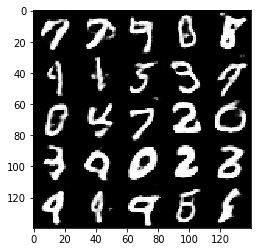

Epoch 2/2... Step 1610... Discriminator Loss: 0.2696... Generator Loss: 2.0739
Epoch 2/2... Step 1620... Discriminator Loss: 0.2694... Generator Loss: 2.7081
Epoch 2/2... Step 1630... Discriminator Loss: 0.1462... Generator Loss: 2.9010
Epoch 2/2... Step 1640... Discriminator Loss: 0.1832... Generator Loss: 3.2104
Epoch 2/2... Step 1650... Discriminator Loss: 0.1741... Generator Loss: 2.6723
Epoch 2/2... Step 1660... Discriminator Loss: 0.1463... Generator Loss: 2.8594
Epoch 2/2... Step 1670... Discriminator Loss: 0.7476... Generator Loss: 3.1911
Epoch 2/2... Step 1680... Discriminator Loss: 1.1444... Generator Loss: 3.4902
Epoch 2/2... Step 1690... Discriminator Loss: 0.6703... Generator Loss: 1.1492
Epoch 2/2... Step 1700... Discriminator Loss: 0.3035... Generator Loss: 2.9313


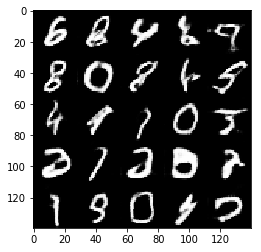

Epoch 2/2... Step 1710... Discriminator Loss: 0.3711... Generator Loss: 2.3556
Epoch 2/2... Step 1720... Discriminator Loss: 0.2580... Generator Loss: 2.6994
Epoch 2/2... Step 1730... Discriminator Loss: 0.2619... Generator Loss: 2.5074
Epoch 2/2... Step 1740... Discriminator Loss: 0.3485... Generator Loss: 1.8899
Epoch 2/2... Step 1750... Discriminator Loss: 0.2756... Generator Loss: 2.5452
Epoch 2/2... Step 1760... Discriminator Loss: 0.4907... Generator Loss: 1.4985
Epoch 2/2... Step 1770... Discriminator Loss: 0.1707... Generator Loss: 2.3757
Epoch 2/2... Step 1780... Discriminator Loss: 0.2503... Generator Loss: 2.4069
Epoch 2/2... Step 1790... Discriminator Loss: 0.1531... Generator Loss: 3.1872
Epoch 2/2... Step 1800... Discriminator Loss: 0.2550... Generator Loss: 2.1051


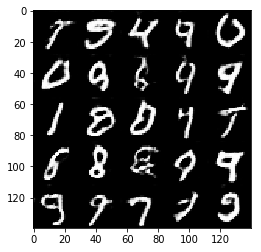

Epoch 2/2... Step 1810... Discriminator Loss: 0.2266... Generator Loss: 2.1838
Epoch 2/2... Step 1820... Discriminator Loss: 0.1289... Generator Loss: 2.5297
Epoch 2/2... Step 1830... Discriminator Loss: 0.1412... Generator Loss: 1.9904
Epoch 2/2... Step 1840... Discriminator Loss: 0.1498... Generator Loss: 2.7091
Epoch 2/2... Step 1850... Discriminator Loss: 0.4640... Generator Loss: 1.2795
Epoch 2/2... Step 1860... Discriminator Loss: 0.9049... Generator Loss: 2.3938
Epoch 2/2... Step 1870... Discriminator Loss: 0.6000... Generator Loss: 1.3353


In [28]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)
pass

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Discriminator Loss: 0.3310... Generator Loss: 1.5987
Epoch 1/1... Step 20... Discriminator Loss: 0.1340... Generator Loss: 2.9616
Epoch 1/1... Step 30... Discriminator Loss: 1.0929... Generator Loss: 13.0125
Epoch 1/1... Step 40... Discriminator Loss: 0.1329... Generator Loss: 4.3326
Epoch 1/1... Step 50... Discriminator Loss: 0.4260... Generator Loss: 3.4122
Epoch 1/1... Step 60... Discriminator Loss: 0.4395... Generator Loss: 4.5147
Epoch 1/1... Step 70... Discriminator Loss: 0.3155... Generator Loss: 7.6205
Epoch 1/1... Step 80... Discriminator Loss: 0.2147... Generator Loss: 2.6592
Epoch 1/1... Step 90... Discriminator Loss: 0.4891... Generator Loss: 1.1549
Epoch 1/1... Step 100... Discriminator Loss: 0.5918... Generator Loss: 1.2031


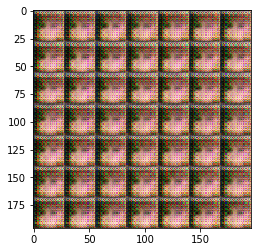

Epoch 1/1... Step 110... Discriminator Loss: 0.3638... Generator Loss: 1.7264
Epoch 1/1... Step 120... Discriminator Loss: 0.0787... Generator Loss: 3.1130
Epoch 1/1... Step 130... Discriminator Loss: 0.1260... Generator Loss: 3.0514
Epoch 1/1... Step 140... Discriminator Loss: 0.2016... Generator Loss: 2.2713
Epoch 1/1... Step 150... Discriminator Loss: 0.1026... Generator Loss: 3.3294
Epoch 1/1... Step 160... Discriminator Loss: 0.1218... Generator Loss: 3.2794
Epoch 1/1... Step 170... Discriminator Loss: 0.0923... Generator Loss: 3.6912
Epoch 1/1... Step 180... Discriminator Loss: 0.0625... Generator Loss: 3.9806
Epoch 1/1... Step 190... Discriminator Loss: 0.1222... Generator Loss: 3.5069
Epoch 1/1... Step 200... Discriminator Loss: 0.0529... Generator Loss: 3.7492


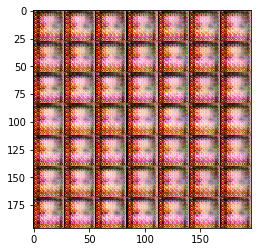

Epoch 1/1... Step 210... Discriminator Loss: 0.0320... Generator Loss: 4.3420
Epoch 1/1... Step 220... Discriminator Loss: 0.0940... Generator Loss: 3.1357
Epoch 1/1... Step 230... Discriminator Loss: 0.0597... Generator Loss: 3.8069
Epoch 1/1... Step 240... Discriminator Loss: 0.0754... Generator Loss: 3.4667
Epoch 1/1... Step 250... Discriminator Loss: 0.4179... Generator Loss: 9.0055
Epoch 1/1... Step 260... Discriminator Loss: 0.0624... Generator Loss: 4.4907
Epoch 1/1... Step 270... Discriminator Loss: 0.2554... Generator Loss: 2.6354
Epoch 1/1... Step 280... Discriminator Loss: 0.2998... Generator Loss: 1.8498
Epoch 1/1... Step 290... Discriminator Loss: 0.9767... Generator Loss: 8.8638
Epoch 1/1... Step 300... Discriminator Loss: 0.3165... Generator Loss: 2.0405


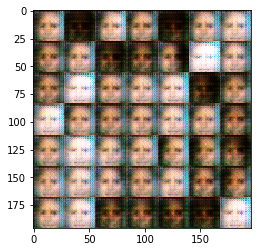

Epoch 1/1... Step 310... Discriminator Loss: 0.2898... Generator Loss: 2.6743
Epoch 1/1... Step 320... Discriminator Loss: 0.1723... Generator Loss: 2.9599
Epoch 1/1... Step 330... Discriminator Loss: 0.2363... Generator Loss: 5.4392
Epoch 1/1... Step 340... Discriminator Loss: 0.3502... Generator Loss: 2.8821
Epoch 1/1... Step 350... Discriminator Loss: 0.1802... Generator Loss: 5.7445
Epoch 1/1... Step 360... Discriminator Loss: 0.5135... Generator Loss: 1.4454
Epoch 1/1... Step 370... Discriminator Loss: 0.1767... Generator Loss: 2.3689
Epoch 1/1... Step 380... Discriminator Loss: 0.1935... Generator Loss: 4.1515
Epoch 1/1... Step 390... Discriminator Loss: 0.2514... Generator Loss: 3.1550
Epoch 1/1... Step 400... Discriminator Loss: 0.3698... Generator Loss: 2.0908


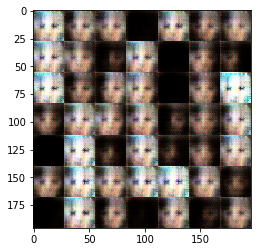

Epoch 1/1... Step 410... Discriminator Loss: 0.4252... Generator Loss: 3.5424
Epoch 1/1... Step 420... Discriminator Loss: 0.1893... Generator Loss: 2.9692
Epoch 1/1... Step 430... Discriminator Loss: 0.9049... Generator Loss: 1.1652
Epoch 1/1... Step 440... Discriminator Loss: 0.2501... Generator Loss: 2.2537
Epoch 1/1... Step 450... Discriminator Loss: 0.5835... Generator Loss: 4.5078
Epoch 1/1... Step 460... Discriminator Loss: 0.2739... Generator Loss: 3.3094
Epoch 1/1... Step 470... Discriminator Loss: 2.1337... Generator Loss: 7.3457
Epoch 1/1... Step 480... Discriminator Loss: 0.4981... Generator Loss: 1.7551
Epoch 1/1... Step 490... Discriminator Loss: 0.4854... Generator Loss: 4.3928
Epoch 1/1... Step 500... Discriminator Loss: 0.4347... Generator Loss: 2.0826


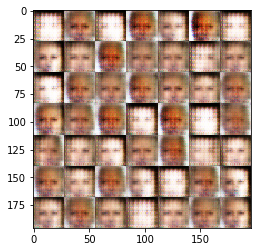

Epoch 1/1... Step 510... Discriminator Loss: 0.6106... Generator Loss: 1.5321
Epoch 1/1... Step 520... Discriminator Loss: 0.8674... Generator Loss: 5.6569
Epoch 1/1... Step 530... Discriminator Loss: 0.3423... Generator Loss: 2.2581
Epoch 1/1... Step 540... Discriminator Loss: 0.3377... Generator Loss: 2.7250
Epoch 1/1... Step 550... Discriminator Loss: 0.3920... Generator Loss: 3.1117
Epoch 1/1... Step 560... Discriminator Loss: 0.1621... Generator Loss: 3.0989
Epoch 1/1... Step 570... Discriminator Loss: 0.4410... Generator Loss: 2.3451
Epoch 1/1... Step 580... Discriminator Loss: 0.1315... Generator Loss: 2.8237
Epoch 1/1... Step 590... Discriminator Loss: 0.4141... Generator Loss: 1.8195
Epoch 1/1... Step 600... Discriminator Loss: 0.3965... Generator Loss: 2.7899


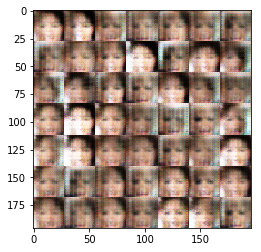

Epoch 1/1... Step 610... Discriminator Loss: 0.2018... Generator Loss: 3.0380
Epoch 1/1... Step 620... Discriminator Loss: 0.2752... Generator Loss: 3.4884
Epoch 1/1... Step 630... Discriminator Loss: 0.2087... Generator Loss: 2.7800
Epoch 1/1... Step 640... Discriminator Loss: 0.1957... Generator Loss: 2.8938
Epoch 1/1... Step 650... Discriminator Loss: 1.0419... Generator Loss: 0.8078
Epoch 1/1... Step 660... Discriminator Loss: 0.5385... Generator Loss: 5.3462
Epoch 1/1... Step 670... Discriminator Loss: 0.5911... Generator Loss: 1.2766
Epoch 1/1... Step 680... Discriminator Loss: 0.4524... Generator Loss: 1.4624
Epoch 1/1... Step 690... Discriminator Loss: 0.2357... Generator Loss: 2.6810
Epoch 1/1... Step 700... Discriminator Loss: 0.2646... Generator Loss: 2.7311


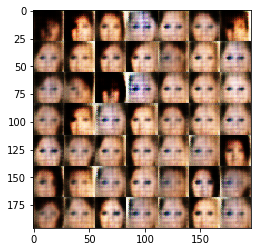

Epoch 1/1... Step 710... Discriminator Loss: 0.1605... Generator Loss: 3.2824
Epoch 1/1... Step 720... Discriminator Loss: 0.3272... Generator Loss: 2.5818
Epoch 1/1... Step 730... Discriminator Loss: 0.3272... Generator Loss: 2.4783
Epoch 1/1... Step 740... Discriminator Loss: 1.1263... Generator Loss: 0.7198
Epoch 1/1... Step 750... Discriminator Loss: 0.4566... Generator Loss: 2.3656
Epoch 1/1... Step 760... Discriminator Loss: 0.4781... Generator Loss: 2.0004
Epoch 1/1... Step 770... Discriminator Loss: 0.3681... Generator Loss: 2.4472
Epoch 1/1... Step 780... Discriminator Loss: 0.4048... Generator Loss: 2.2966
Epoch 1/1... Step 790... Discriminator Loss: 0.6075... Generator Loss: 1.4288
Epoch 1/1... Step 800... Discriminator Loss: 0.5580... Generator Loss: 4.3957


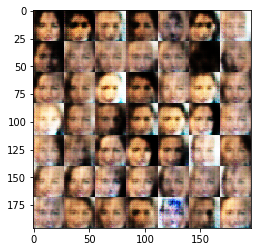

Epoch 1/1... Step 810... Discriminator Loss: 0.7322... Generator Loss: 1.0552
Epoch 1/1... Step 820... Discriminator Loss: 0.2078... Generator Loss: 5.4575
Epoch 1/1... Step 830... Discriminator Loss: 0.3674... Generator Loss: 2.6262
Epoch 1/1... Step 840... Discriminator Loss: 0.4789... Generator Loss: 3.0919
Epoch 1/1... Step 850... Discriminator Loss: 0.3499... Generator Loss: 3.0266
Epoch 1/1... Step 860... Discriminator Loss: 1.0527... Generator Loss: 0.9064
Epoch 1/1... Step 870... Discriminator Loss: 0.3990... Generator Loss: 1.8996
Epoch 1/1... Step 880... Discriminator Loss: 2.3209... Generator Loss: 6.8013
Epoch 1/1... Step 890... Discriminator Loss: 0.4078... Generator Loss: 3.6973
Epoch 1/1... Step 900... Discriminator Loss: 0.8295... Generator Loss: 4.1875


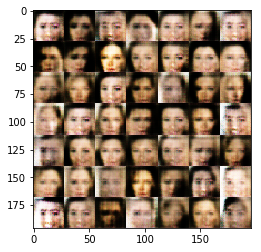

Epoch 1/1... Step 910... Discriminator Loss: 0.5620... Generator Loss: 1.8207
Epoch 1/1... Step 920... Discriminator Loss: 0.5450... Generator Loss: 1.5188
Epoch 1/1... Step 930... Discriminator Loss: 0.5430... Generator Loss: 1.5526
Epoch 1/1... Step 940... Discriminator Loss: 0.3645... Generator Loss: 2.2152
Epoch 1/1... Step 950... Discriminator Loss: 0.5709... Generator Loss: 1.4977
Epoch 1/1... Step 960... Discriminator Loss: 0.2460... Generator Loss: 3.4184
Epoch 1/1... Step 970... Discriminator Loss: 0.3250... Generator Loss: 2.7099
Epoch 1/1... Step 980... Discriminator Loss: 0.3034... Generator Loss: 2.7490
Epoch 1/1... Step 990... Discriminator Loss: 0.4155... Generator Loss: 4.0669
Epoch 1/1... Step 1000... Discriminator Loss: 0.4646... Generator Loss: 1.5654


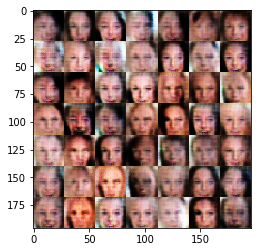

Epoch 1/1... Step 1010... Discriminator Loss: 0.4482... Generator Loss: 1.8386
Epoch 1/1... Step 1020... Discriminator Loss: 0.5509... Generator Loss: 1.7008
Epoch 1/1... Step 1030... Discriminator Loss: 0.4899... Generator Loss: 2.8964
Epoch 1/1... Step 1040... Discriminator Loss: 0.4179... Generator Loss: 2.2239
Epoch 1/1... Step 1050... Discriminator Loss: 0.3854... Generator Loss: 3.2822
Epoch 1/1... Step 1060... Discriminator Loss: 0.4213... Generator Loss: 1.6368
Epoch 1/1... Step 1070... Discriminator Loss: 0.2983... Generator Loss: 3.7249
Epoch 1/1... Step 1080... Discriminator Loss: 0.2355... Generator Loss: 2.2008
Epoch 1/1... Step 1090... Discriminator Loss: 0.3329... Generator Loss: 2.4636
Epoch 1/1... Step 1100... Discriminator Loss: 0.3683... Generator Loss: 3.6854


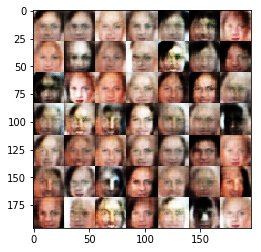

Epoch 1/1... Step 1110... Discriminator Loss: 0.5385... Generator Loss: 1.3560
Epoch 1/1... Step 1120... Discriminator Loss: 0.2981... Generator Loss: 2.9354
Epoch 1/1... Step 1130... Discriminator Loss: 0.4019... Generator Loss: 3.5611
Epoch 1/1... Step 1140... Discriminator Loss: 0.4560... Generator Loss: 2.5930
Epoch 1/1... Step 1150... Discriminator Loss: 0.4577... Generator Loss: 1.7206
Epoch 1/1... Step 1160... Discriminator Loss: 0.3932... Generator Loss: 2.6185
Epoch 1/1... Step 1170... Discriminator Loss: 0.4167... Generator Loss: 1.9058
Epoch 1/1... Step 1180... Discriminator Loss: 0.2557... Generator Loss: 2.9611
Epoch 1/1... Step 1190... Discriminator Loss: 0.2942... Generator Loss: 2.7021
Epoch 1/1... Step 1200... Discriminator Loss: 0.2664... Generator Loss: 2.5594


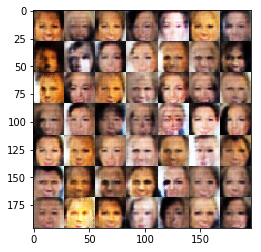

Epoch 1/1... Step 1210... Discriminator Loss: 0.5774... Generator Loss: 1.3326
Epoch 1/1... Step 1220... Discriminator Loss: 0.5118... Generator Loss: 4.3688
Epoch 1/1... Step 1230... Discriminator Loss: 0.6841... Generator Loss: 1.1448
Epoch 1/1... Step 1240... Discriminator Loss: 0.5532... Generator Loss: 1.6119
Epoch 1/1... Step 1250... Discriminator Loss: 0.3229... Generator Loss: 2.2588
Epoch 1/1... Step 1260... Discriminator Loss: 0.4308... Generator Loss: 1.7741
Epoch 1/1... Step 1270... Discriminator Loss: 0.4022... Generator Loss: 4.0626
Epoch 1/1... Step 1280... Discriminator Loss: 0.3285... Generator Loss: 2.3869
Epoch 1/1... Step 1290... Discriminator Loss: 0.4573... Generator Loss: 1.5489
Epoch 1/1... Step 1300... Discriminator Loss: 0.5522... Generator Loss: 4.1053


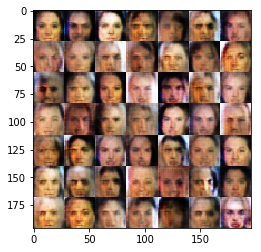

Epoch 1/1... Step 1310... Discriminator Loss: 0.3717... Generator Loss: 2.1727
Epoch 1/1... Step 1320... Discriminator Loss: 0.2989... Generator Loss: 3.5487
Epoch 1/1... Step 1330... Discriminator Loss: 0.3762... Generator Loss: 2.0767
Epoch 1/1... Step 1340... Discriminator Loss: 0.2991... Generator Loss: 3.5084
Epoch 1/1... Step 1350... Discriminator Loss: 2.2700... Generator Loss: 0.2574
Epoch 1/1... Step 1360... Discriminator Loss: 1.0672... Generator Loss: 4.9310
Epoch 1/1... Step 1370... Discriminator Loss: 0.3818... Generator Loss: 3.0505
Epoch 1/1... Step 1380... Discriminator Loss: 0.5505... Generator Loss: 1.8621
Epoch 1/1... Step 1390... Discriminator Loss: 0.3272... Generator Loss: 2.3697
Epoch 1/1... Step 1400... Discriminator Loss: 0.4224... Generator Loss: 2.0294


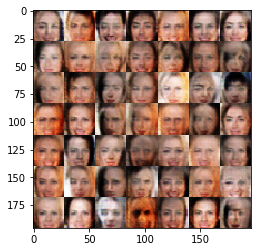

Epoch 1/1... Step 1410... Discriminator Loss: 0.3153... Generator Loss: 2.3852
Epoch 1/1... Step 1420... Discriminator Loss: 0.3906... Generator Loss: 2.6326
Epoch 1/1... Step 1430... Discriminator Loss: 1.0100... Generator Loss: 0.6384
Epoch 1/1... Step 1440... Discriminator Loss: 0.4251... Generator Loss: 2.6678
Epoch 1/1... Step 1450... Discriminator Loss: 0.4382... Generator Loss: 3.0429
Epoch 1/1... Step 1460... Discriminator Loss: 0.4496... Generator Loss: 2.5161
Epoch 1/1... Step 1470... Discriminator Loss: 0.4141... Generator Loss: 2.1683
Epoch 1/1... Step 1480... Discriminator Loss: 0.4071... Generator Loss: 1.6933
Epoch 1/1... Step 1490... Discriminator Loss: 1.0471... Generator Loss: 0.6038
Epoch 1/1... Step 1500... Discriminator Loss: 0.5779... Generator Loss: 2.1174


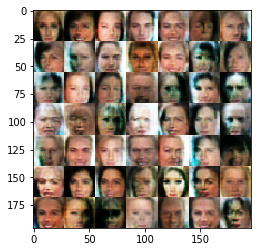

Epoch 1/1... Step 1510... Discriminator Loss: 0.3313... Generator Loss: 1.9536
Epoch 1/1... Step 1520... Discriminator Loss: 0.3481... Generator Loss: 2.6076
Epoch 1/1... Step 1530... Discriminator Loss: 0.3274... Generator Loss: 2.1497
Epoch 1/1... Step 1540... Discriminator Loss: 0.4839... Generator Loss: 1.4958
Epoch 1/1... Step 1550... Discriminator Loss: 0.5279... Generator Loss: 4.6273
Epoch 1/1... Step 1560... Discriminator Loss: 0.6366... Generator Loss: 3.9312
Epoch 1/1... Step 1570... Discriminator Loss: 0.4910... Generator Loss: 1.7624
Epoch 1/1... Step 1580... Discriminator Loss: 0.7303... Generator Loss: 3.6263
Epoch 1/1... Step 1590... Discriminator Loss: 0.3141... Generator Loss: 3.1734
Epoch 1/1... Step 1600... Discriminator Loss: 0.4198... Generator Loss: 2.2612


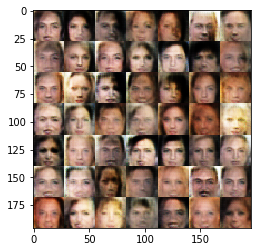

Epoch 1/1... Step 1610... Discriminator Loss: 1.4876... Generator Loss: 0.5250
Epoch 1/1... Step 1620... Discriminator Loss: 0.4797... Generator Loss: 1.9682
Epoch 1/1... Step 1630... Discriminator Loss: 0.4674... Generator Loss: 1.7452
Epoch 1/1... Step 1640... Discriminator Loss: 0.5866... Generator Loss: 3.2082
Epoch 1/1... Step 1650... Discriminator Loss: 0.5995... Generator Loss: 2.9450
Epoch 1/1... Step 1660... Discriminator Loss: 0.3264... Generator Loss: 2.3472
Epoch 1/1... Step 1670... Discriminator Loss: 0.7283... Generator Loss: 1.1366
Epoch 1/1... Step 1680... Discriminator Loss: 0.4043... Generator Loss: 1.5854
Epoch 1/1... Step 1690... Discriminator Loss: 0.2966... Generator Loss: 2.5240
Epoch 1/1... Step 1700... Discriminator Loss: 0.4167... Generator Loss: 3.4324


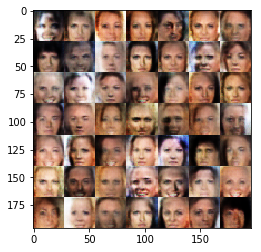

Epoch 1/1... Step 1710... Discriminator Loss: 0.5338... Generator Loss: 1.4892
Epoch 1/1... Step 1720... Discriminator Loss: 0.3936... Generator Loss: 1.8035
Epoch 1/1... Step 1730... Discriminator Loss: 0.5487... Generator Loss: 1.4341
Epoch 1/1... Step 1740... Discriminator Loss: 0.3254... Generator Loss: 2.9321
Epoch 1/1... Step 1750... Discriminator Loss: 0.4967... Generator Loss: 3.5435
Epoch 1/1... Step 1760... Discriminator Loss: 1.3005... Generator Loss: 6.5458
Epoch 1/1... Step 1770... Discriminator Loss: 0.8679... Generator Loss: 3.5302
Epoch 1/1... Step 1780... Discriminator Loss: 0.3945... Generator Loss: 2.3588
Epoch 1/1... Step 1790... Discriminator Loss: 0.3068... Generator Loss: 2.8758
Epoch 1/1... Step 1800... Discriminator Loss: 0.5274... Generator Loss: 1.1868


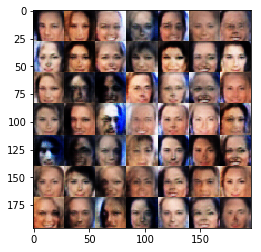

Epoch 1/1... Step 1810... Discriminator Loss: 0.5576... Generator Loss: 3.1582
Epoch 1/1... Step 1820... Discriminator Loss: 0.4466... Generator Loss: 2.0003
Epoch 1/1... Step 1830... Discriminator Loss: 0.5853... Generator Loss: 1.2297
Epoch 1/1... Step 1840... Discriminator Loss: 0.4089... Generator Loss: 2.5935
Epoch 1/1... Step 1850... Discriminator Loss: 0.4501... Generator Loss: 2.0312
Epoch 1/1... Step 1860... Discriminator Loss: 0.3892... Generator Loss: 2.3004
Epoch 1/1... Step 1870... Discriminator Loss: 0.7864... Generator Loss: 1.0686
Epoch 1/1... Step 1880... Discriminator Loss: 0.7220... Generator Loss: 1.1807
Epoch 1/1... Step 1890... Discriminator Loss: 0.4755... Generator Loss: 1.3444
Epoch 1/1... Step 1900... Discriminator Loss: 0.4948... Generator Loss: 1.2809


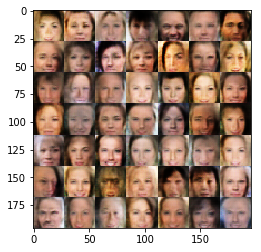

Epoch 1/1... Step 1910... Discriminator Loss: 0.7808... Generator Loss: 3.7704
Epoch 1/1... Step 1920... Discriminator Loss: 0.8831... Generator Loss: 4.1568
Epoch 1/1... Step 1930... Discriminator Loss: 0.4660... Generator Loss: 1.4628
Epoch 1/1... Step 1940... Discriminator Loss: 0.4838... Generator Loss: 2.0244
Epoch 1/1... Step 1950... Discriminator Loss: 0.6167... Generator Loss: 1.1802
Epoch 1/1... Step 1960... Discriminator Loss: 0.4099... Generator Loss: 3.3606
Epoch 1/1... Step 1970... Discriminator Loss: 0.4690... Generator Loss: 2.0120
Epoch 1/1... Step 1980... Discriminator Loss: 0.5221... Generator Loss: 2.4097
Epoch 1/1... Step 1990... Discriminator Loss: 0.9248... Generator Loss: 0.7932
Epoch 1/1... Step 2000... Discriminator Loss: 0.5590... Generator Loss: 2.9693


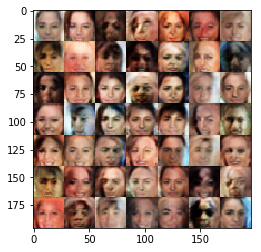

Epoch 1/1... Step 2010... Discriminator Loss: 0.5780... Generator Loss: 1.2928
Epoch 1/1... Step 2020... Discriminator Loss: 0.4265... Generator Loss: 2.1614
Epoch 1/1... Step 2030... Discriminator Loss: 0.7618... Generator Loss: 0.9367
Epoch 1/1... Step 2040... Discriminator Loss: 0.8709... Generator Loss: 3.8969
Epoch 1/1... Step 2050... Discriminator Loss: 0.8483... Generator Loss: 0.8793
Epoch 1/1... Step 2060... Discriminator Loss: 0.8246... Generator Loss: 1.0345
Epoch 1/1... Step 2070... Discriminator Loss: 0.5883... Generator Loss: 1.3193
Epoch 1/1... Step 2080... Discriminator Loss: 0.4568... Generator Loss: 2.6065
Epoch 1/1... Step 2090... Discriminator Loss: 0.5080... Generator Loss: 1.7278
Epoch 1/1... Step 2100... Discriminator Loss: 0.7280... Generator Loss: 1.0138


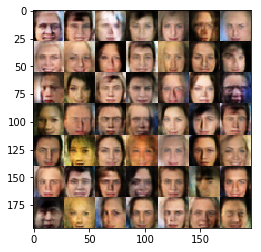

Epoch 1/1... Step 2110... Discriminator Loss: 0.4482... Generator Loss: 2.3868
Epoch 1/1... Step 2120... Discriminator Loss: 0.5757... Generator Loss: 1.1930
Epoch 1/1... Step 2130... Discriminator Loss: 0.4097... Generator Loss: 3.0817
Epoch 1/1... Step 2140... Discriminator Loss: 0.4869... Generator Loss: 1.4289
Epoch 1/1... Step 2150... Discriminator Loss: 0.6866... Generator Loss: 1.3855
Epoch 1/1... Step 2160... Discriminator Loss: 0.3783... Generator Loss: 2.2315
Epoch 1/1... Step 2170... Discriminator Loss: 0.7392... Generator Loss: 2.9053
Epoch 1/1... Step 2180... Discriminator Loss: 0.8588... Generator Loss: 1.9494
Epoch 1/1... Step 2190... Discriminator Loss: 0.7809... Generator Loss: 3.4541
Epoch 1/1... Step 2200... Discriminator Loss: 0.3809... Generator Loss: 2.2723


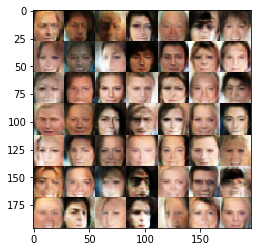

Epoch 1/1... Step 2210... Discriminator Loss: 0.5142... Generator Loss: 1.2858
Epoch 1/1... Step 2220... Discriminator Loss: 0.6656... Generator Loss: 1.2720
Epoch 1/1... Step 2230... Discriminator Loss: 0.5050... Generator Loss: 1.6097
Epoch 1/1... Step 2240... Discriminator Loss: 0.4814... Generator Loss: 3.1097
Epoch 1/1... Step 2250... Discriminator Loss: 0.6715... Generator Loss: 1.0822
Epoch 1/1... Step 2260... Discriminator Loss: 0.5855... Generator Loss: 1.4591
Epoch 1/1... Step 2270... Discriminator Loss: 0.4417... Generator Loss: 1.7577
Epoch 1/1... Step 2280... Discriminator Loss: 0.4808... Generator Loss: 1.4385
Epoch 1/1... Step 2290... Discriminator Loss: 0.4151... Generator Loss: 1.9605
Epoch 1/1... Step 2300... Discriminator Loss: 0.8217... Generator Loss: 3.7946


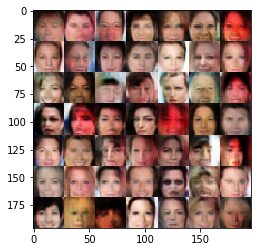

Epoch 1/1... Step 2310... Discriminator Loss: 0.5079... Generator Loss: 1.4857
Epoch 1/1... Step 2320... Discriminator Loss: 0.4770... Generator Loss: 3.6435
Epoch 1/1... Step 2330... Discriminator Loss: 0.4958... Generator Loss: 1.9817
Epoch 1/1... Step 2340... Discriminator Loss: 0.4243... Generator Loss: 1.9294
Epoch 1/1... Step 2350... Discriminator Loss: 0.6250... Generator Loss: 1.3899
Epoch 1/1... Step 2360... Discriminator Loss: 1.0275... Generator Loss: 4.1449
Epoch 1/1... Step 2370... Discriminator Loss: 0.4587... Generator Loss: 2.3244
Epoch 1/1... Step 2380... Discriminator Loss: 1.2499... Generator Loss: 4.8042
Epoch 1/1... Step 2390... Discriminator Loss: 0.4987... Generator Loss: 1.5258
Epoch 1/1... Step 2400... Discriminator Loss: 0.5373... Generator Loss: 1.2637


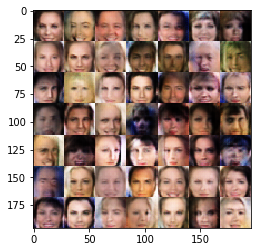

Epoch 1/1... Step 2410... Discriminator Loss: 0.7502... Generator Loss: 3.5817
Epoch 1/1... Step 2420... Discriminator Loss: 0.5436... Generator Loss: 1.3989
Epoch 1/1... Step 2430... Discriminator Loss: 0.3727... Generator Loss: 2.2514
Epoch 1/1... Step 2440... Discriminator Loss: 0.7757... Generator Loss: 1.0222
Epoch 1/1... Step 2450... Discriminator Loss: 0.6020... Generator Loss: 1.5767
Epoch 1/1... Step 2460... Discriminator Loss: 0.9533... Generator Loss: 0.5243
Epoch 1/1... Step 2470... Discriminator Loss: 0.5373... Generator Loss: 1.9207
Epoch 1/1... Step 2480... Discriminator Loss: 0.6126... Generator Loss: 1.3722
Epoch 1/1... Step 2490... Discriminator Loss: 0.5182... Generator Loss: 1.8434
Epoch 1/1... Step 2500... Discriminator Loss: 0.6467... Generator Loss: 1.1515


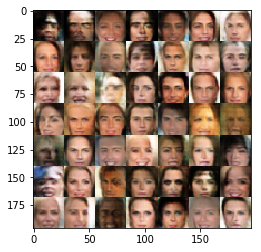

Epoch 1/1... Step 2510... Discriminator Loss: 0.4358... Generator Loss: 1.6302
Epoch 1/1... Step 2520... Discriminator Loss: 0.4777... Generator Loss: 1.5325
Epoch 1/1... Step 2530... Discriminator Loss: 0.3891... Generator Loss: 1.9577
Epoch 1/1... Step 2540... Discriminator Loss: 0.7575... Generator Loss: 3.5657
Epoch 1/1... Step 2550... Discriminator Loss: 0.5498... Generator Loss: 1.8431
Epoch 1/1... Step 2560... Discriminator Loss: 1.4884... Generator Loss: 5.3816
Epoch 1/1... Step 2570... Discriminator Loss: 0.4688... Generator Loss: 2.2607
Epoch 1/1... Step 2580... Discriminator Loss: 0.5110... Generator Loss: 3.5733
Epoch 1/1... Step 2590... Discriminator Loss: 0.7841... Generator Loss: 1.2824
Epoch 1/1... Step 2600... Discriminator Loss: 0.4809... Generator Loss: 2.1323


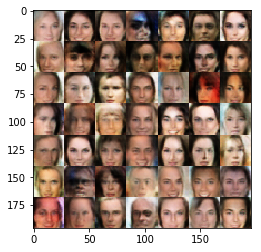

Epoch 1/1... Step 2610... Discriminator Loss: 0.7569... Generator Loss: 1.6158
Epoch 1/1... Step 2620... Discriminator Loss: 0.4468... Generator Loss: 1.9762
Epoch 1/1... Step 2630... Discriminator Loss: 0.4373... Generator Loss: 1.9683
Epoch 1/1... Step 2640... Discriminator Loss: 0.6443... Generator Loss: 1.1072
Epoch 1/1... Step 2650... Discriminator Loss: 0.6695... Generator Loss: 3.7268
Epoch 1/1... Step 2660... Discriminator Loss: 2.6606... Generator Loss: 0.1392
Epoch 1/1... Step 2670... Discriminator Loss: 0.5216... Generator Loss: 1.4703
Epoch 1/1... Step 2680... Discriminator Loss: 0.7836... Generator Loss: 1.0326
Epoch 1/1... Step 2690... Discriminator Loss: 1.1100... Generator Loss: 0.6668
Epoch 1/1... Step 2700... Discriminator Loss: 0.7016... Generator Loss: 1.2757


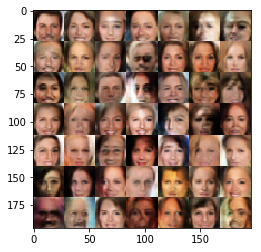

Epoch 1/1... Step 2710... Discriminator Loss: 0.5360... Generator Loss: 1.6877
Epoch 1/1... Step 2720... Discriminator Loss: 0.4930... Generator Loss: 1.8593
Epoch 1/1... Step 2730... Discriminator Loss: 0.4588... Generator Loss: 2.5087
Epoch 1/1... Step 2740... Discriminator Loss: 0.9180... Generator Loss: 0.7538
Epoch 1/1... Step 2750... Discriminator Loss: 1.4470... Generator Loss: 0.6187
Epoch 1/1... Step 2760... Discriminator Loss: 0.5224... Generator Loss: 1.5180
Epoch 1/1... Step 2770... Discriminator Loss: 0.4679... Generator Loss: 1.7239
Epoch 1/1... Step 2780... Discriminator Loss: 0.4895... Generator Loss: 1.7852
Epoch 1/1... Step 2790... Discriminator Loss: 0.4508... Generator Loss: 2.1543
Epoch 1/1... Step 2800... Discriminator Loss: 0.4575... Generator Loss: 2.7128


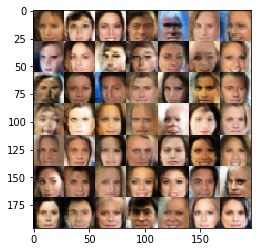

Epoch 1/1... Step 2810... Discriminator Loss: 0.3587... Generator Loss: 1.9690
Epoch 1/1... Step 2820... Discriminator Loss: 0.4277... Generator Loss: 2.2853
Epoch 1/1... Step 2830... Discriminator Loss: 0.4215... Generator Loss: 2.2403
Epoch 1/1... Step 2840... Discriminator Loss: 0.6203... Generator Loss: 1.1668
Epoch 1/1... Step 2850... Discriminator Loss: 0.4543... Generator Loss: 3.0582
Epoch 1/1... Step 2860... Discriminator Loss: 0.9299... Generator Loss: 0.8332
Epoch 1/1... Step 2870... Discriminator Loss: 0.4726... Generator Loss: 2.2690
Epoch 1/1... Step 2880... Discriminator Loss: 0.5021... Generator Loss: 1.8522
Epoch 1/1... Step 2890... Discriminator Loss: 0.4240... Generator Loss: 2.1820
Epoch 1/1... Step 2900... Discriminator Loss: 0.7548... Generator Loss: 2.7162


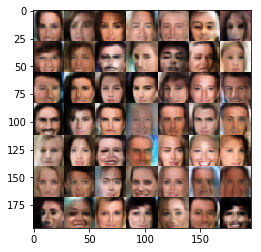

Epoch 1/1... Step 2910... Discriminator Loss: 0.5265... Generator Loss: 1.9299
Epoch 1/1... Step 2920... Discriminator Loss: 0.5837... Generator Loss: 3.2980
Epoch 1/1... Step 2930... Discriminator Loss: 0.8255... Generator Loss: 1.0263
Epoch 1/1... Step 2940... Discriminator Loss: 0.6230... Generator Loss: 3.2455
Epoch 1/1... Step 2950... Discriminator Loss: 0.5576... Generator Loss: 1.3745
Epoch 1/1... Step 2960... Discriminator Loss: 0.4781... Generator Loss: 1.5455
Epoch 1/1... Step 2970... Discriminator Loss: 0.5525... Generator Loss: 2.9774
Epoch 1/1... Step 2980... Discriminator Loss: 1.9787... Generator Loss: 4.9970
Epoch 1/1... Step 2990... Discriminator Loss: 0.6199... Generator Loss: 2.0432
Epoch 1/1... Step 3000... Discriminator Loss: 0.6696... Generator Loss: 1.6682


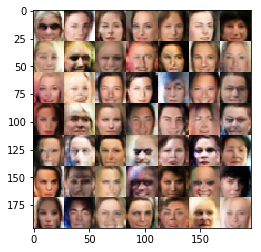

Epoch 1/1... Step 3010... Discriminator Loss: 0.4017... Generator Loss: 2.1664
Epoch 1/1... Step 3020... Discriminator Loss: 0.5962... Generator Loss: 1.4782
Epoch 1/1... Step 3030... Discriminator Loss: 0.5631... Generator Loss: 1.3062
Epoch 1/1... Step 3040... Discriminator Loss: 0.4152... Generator Loss: 2.4871
Epoch 1/1... Step 3050... Discriminator Loss: 0.3703... Generator Loss: 2.3074
Epoch 1/1... Step 3060... Discriminator Loss: 0.6540... Generator Loss: 0.8698
Epoch 1/1... Step 3070... Discriminator Loss: 0.3614... Generator Loss: 1.8524
Epoch 1/1... Step 3080... Discriminator Loss: 1.1611... Generator Loss: 0.6109
Epoch 1/1... Step 3090... Discriminator Loss: 0.5987... Generator Loss: 1.5437
Epoch 1/1... Step 3100... Discriminator Loss: 0.4709... Generator Loss: 2.2457


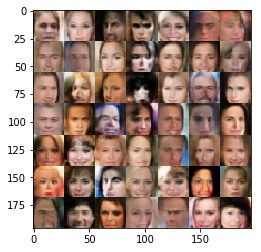

Epoch 1/1... Step 3110... Discriminator Loss: 0.4325... Generator Loss: 2.5247
Epoch 1/1... Step 3120... Discriminator Loss: 0.4198... Generator Loss: 1.9342
Epoch 1/1... Step 3130... Discriminator Loss: 0.4936... Generator Loss: 1.5407
Epoch 1/1... Step 3140... Discriminator Loss: 2.0815... Generator Loss: 5.0921
Epoch 1/1... Step 3150... Discriminator Loss: 0.4892... Generator Loss: 1.7492
Epoch 1/1... Step 3160... Discriminator Loss: 0.4930... Generator Loss: 1.7610


In [30]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.